In [1]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


2024-03-28 13:39:49.763275: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-28 13:39:50.112274: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-28 13:39:50.293746: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-28 13:39:51.670933: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

Num GPUs Available:  1


In [3]:
import os

def get_folder_size(folder):
    total_size = 0
    # Use os.walk to iterate through all subdirectories and files
    for root, dirs, files in os.walk(folder):
        for file in files:
            # Join the path to get the full file path
            filepath = os.path.join(root, file)
            # Use os.path.getsize to get the file size and add it to the total
            if os.path.exists(filepath):  # Checks if file still exists
                total_size += os.path.getsize(filepath)
    return total_size

# Specify the path to your folder
folder_path = 'DICE'

# Calculate the folder size
folder_size = get_folder_size(folder_path)

# Print the result in bytes
print(f"The total size of the folder '{folder_path}' is {folder_size} bytes.")

# Optionally, you can print the size in a more readable format like KB, MB, or GB
def size_format(size):
    # Define the suffixes for size
    suffixes = ['B', 'KB', 'MB', 'GB', 'TB', 'PB']
    suffix_index = 0
    while size >= 1024 and suffix_index < len(suffixes) - 1:
        suffix_index += 1  # Increment to get to the next unit of measurement
        size /= 1024.0     # Divide size by 1024 to convert to the next unit
    return f"{size:.2f} {suffixes[suffix_index]}"

# Print the formatted size
formatted_size = size_format(folder_size)
print(f"Formatted size: {formatted_size}")


The total size of the folder 'DICE' is 1199442393 bytes.
Formatted size: 1.12 GB


In [5]:
import shutil
import os

# Specify the directory to be deleted
directory_path = 'DICE'

# Check if the directory exists
if os.path.exists(directory_path):
    # Forcefully remove the directory and all its contents
    shutil.rmtree(directory_path)
    print(f"Directory '{directory_path}' has been deleted.")
else:
    print(f"Directory '{directory_path}' does not exist.")


Directory 'DICE' has been deleted.


## Segmentation using U-net

In [2]:
import numpy as np
import nibabel as nib
import os
import sys
import pandas as pd
from glob import glob
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import binary_crossentropy
from scipy.ndimage import gaussian_filter, map_coordinates
from skimage.transform import resize
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dropout, concatenate, BatchNormalization, Activation, Concatenate
from tensorflow.keras.models import Model, load_model
%matplotlib inline

## Data Load

In [3]:
# data_path = 'drive/MyDrive/BiS400 Data/Segmentation/'
data_path = os.getcwd() +'/'
tasks = [x for x in os.listdir(data_path) if x.startswith('Task')]
task = tasks[0]

In [4]:
# Paths
path_tr = data_path+task+'/imagesTr'
path_tr_label = data_path+task+'/labelsTr'

imglist_tr = glob(path_tr+'/*.gz')
imglist_tr_label = glob(path_tr_label+'/*.gz')

# Test Data Set Number
include_numbers = ['24', '26', '29', '30']

imglist_tr_test = [path for path in imglist_tr if any(num in os.path.basename(path) for num in include_numbers)]
imglist_tr_train = [path for path in imglist_tr if path not in imglist_tr_test]

imglist_tr_label_test = [path for path in imglist_tr_label if any(num in os.path.basename(path) for num in include_numbers)]
imglist_tr_label_train = [path for path in imglist_tr_label if path not in imglist_tr_label_test]

print('num_train = {}, num_test = {}'.format(len(imglist_tr_train), len(imglist_tr_test)))

num_train = 16, num_test = 4


In [5]:
imglist_tr_train

['/home/elicer/Task02_Heart/imagesTr/la_007.nii.gz',
 '/home/elicer/Task02_Heart/imagesTr/la_019.nii.gz',
 '/home/elicer/Task02_Heart/imagesTr/la_023.nii.gz',
 '/home/elicer/Task02_Heart/imagesTr/la_005.nii.gz',
 '/home/elicer/Task02_Heart/imagesTr/la_009.nii.gz',
 '/home/elicer/Task02_Heart/imagesTr/la_017.nii.gz',
 '/home/elicer/Task02_Heart/imagesTr/la_021.nii.gz',
 '/home/elicer/Task02_Heart/imagesTr/la_003.nii.gz',
 '/home/elicer/Task02_Heart/imagesTr/la_011.nii.gz',
 '/home/elicer/Task02_Heart/imagesTr/la_022.nii.gz',
 '/home/elicer/Task02_Heart/imagesTr/la_014.nii.gz',
 '/home/elicer/Task02_Heart/imagesTr/la_018.nii.gz',
 '/home/elicer/Task02_Heart/imagesTr/la_020.nii.gz',
 '/home/elicer/Task02_Heart/imagesTr/la_004.nii.gz',
 '/home/elicer/Task02_Heart/imagesTr/la_016.nii.gz',
 '/home/elicer/Task02_Heart/imagesTr/la_010.nii.gz']

In [6]:
imglist_tr_label_train

['/home/elicer/Task02_Heart/labelsTr/la_007.nii.gz',
 '/home/elicer/Task02_Heart/labelsTr/la_019.nii.gz',
 '/home/elicer/Task02_Heart/labelsTr/la_023.nii.gz',
 '/home/elicer/Task02_Heart/labelsTr/la_005.nii.gz',
 '/home/elicer/Task02_Heart/labelsTr/la_009.nii.gz',
 '/home/elicer/Task02_Heart/labelsTr/la_017.nii.gz',
 '/home/elicer/Task02_Heart/labelsTr/la_021.nii.gz',
 '/home/elicer/Task02_Heart/labelsTr/la_003.nii.gz',
 '/home/elicer/Task02_Heart/labelsTr/la_011.nii.gz',
 '/home/elicer/Task02_Heart/labelsTr/la_022.nii.gz',
 '/home/elicer/Task02_Heart/labelsTr/la_014.nii.gz',
 '/home/elicer/Task02_Heart/labelsTr/la_018.nii.gz',
 '/home/elicer/Task02_Heart/labelsTr/la_020.nii.gz',
 '/home/elicer/Task02_Heart/labelsTr/la_004.nii.gz',
 '/home/elicer/Task02_Heart/labelsTr/la_016.nii.gz',
 '/home/elicer/Task02_Heart/labelsTr/la_010.nii.gz']

In [7]:
# Dimensions
print('Train:')
for img_name in imglist_tr_train:
    img = nib.load(img_name)
    print(img.shape)
    
print('Train Label:')
for img_name in imglist_tr_label_train[:5]:
    img = nib.load(img_name)
    print(img.shape)
    
print('Test:')
for img_name in imglist_tr_test:
    img = nib.load(img_name)
    print(img.shape)

# Images
img = nib.load(imglist_tr_train[0]).get_fdata()
label = nib.load(imglist_tr_label_train[0]).get_fdata()
print('Image Min-Max values: Image={},{} and label={},{}'.format(img.max(), img.min(), label.max(), label.min()))
print('Number of subclasses = ', int(label.max())+1)

Train:
(320, 320, 130)
(320, 320, 100)
(320, 320, 110)
(320, 320, 120)
(320, 320, 100)
(320, 320, 120)
(320, 320, 100)
(320, 320, 130)
(320, 320, 120)
(320, 320, 110)
(320, 320, 120)
(320, 320, 122)
(320, 320, 110)
(320, 320, 110)
(320, 320, 90)
(320, 320, 120)
Train Label:
(320, 320, 130)
(320, 320, 100)
(320, 320, 110)
(320, 320, 120)
(320, 320, 100)
Test:
(320, 320, 109)
(320, 320, 110)
(320, 320, 120)
(320, 320, 120)
Image Min-Max values: Image=1873.0,0.0 and label=1.0,0.0
Number of subclasses =  2


## Sample Display

Image Min-Max values: Image=1662.0,0.0 and label=1.0,0.0
Number of subclasses =  2


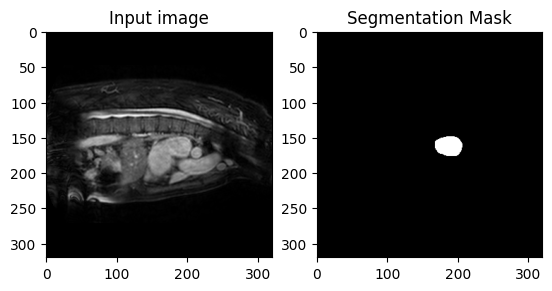

In [8]:
# Images
img = nib.load(imglist_tr_train[1]).get_fdata()
label = nib.load(imglist_tr_label_train[1]).get_fdata()
print('Image Min-Max values: Image={},{} and label={},{}'.format(img.max(), img.min(), label.max(), label.min()))
print('Number of subclasses = ', int(label.max())+1)

# Sample Visualization
slice_idx = img.shape[2] // 2

ax = plt.subplot(1,2,1)
ax.imshow(img[:,:,slice_idx], cmap='gray')
ax.set_title('Input image')

ax = plt.subplot(1,2,2)
ax.imshow(label[:,:,slice_idx], cmap='gray')
ax.set_title('Segmentation Mask')
plt.show()
print('\n')

## Define U-net model 

In [9]:
def conv_block(input_tensor, num_filters, dropout_rate=0.5):
    x = Conv2D(num_filters, (3, 3), padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(num_filters, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    if dropout_rate > 0:
        x = Dropout(dropout_rate)(x)
    return x

def unet_2d(input_size=(320, 320, 1), dropout_rate=0.5):
    inputs = Input(input_size)
    
    # Contracting Path
    c1 = conv_block(inputs, 64, 0)  # Typically, dropout is not applied in the first layer
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = conv_block(p1, 128)
    p2 = MaxPooling2D((2, 2))(c2)
    
    c3 = conv_block(p2, 256)
    p3 = MaxPooling2D((2, 2))(c3)
    
    c4 = conv_block(p3, 512)
    p4 = MaxPooling2D((2, 2))(c4)
    
    c5 = conv_block(p4, 1024, dropout_rate)
    
    # Expansive Path
    u6 = UpSampling2D((2, 2))(c5)
    u6 = Concatenate()([u6, c4])
    c6 = conv_block(u6, 512)
    
    u7 = UpSampling2D((2, 2))(c6)
    u7 = Concatenate()([u7, c3])
    c7 = conv_block(u7, 256)
    
    u8 = UpSampling2D((2, 2))(c7)
    u8 = Concatenate()([u8, c2])
    c8 = conv_block(u8, 128)
    
    u9 = UpSampling2D((2, 2))(c8)
    u9 = Concatenate()([u9, c1])
    c9 = conv_block(u9, 64, 0)  # Dropout not typically applied in the final layer before output
    
    # Final convolution
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    return model

In [10]:
def unet_2d_shallow(input_size=(320, 320, 1)):
    inputs = Input(input_size)

    # Contracting Path
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    # Bottleneck
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)

    # Expansive Path
    u4 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c3)
    u4 = Concatenate()([u4, c2])
    c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(u4)
    c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(c4)

    u5 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c4)
    u5 = Concatenate()([u5, c1])
    c5 = Conv2D(64, (3, 3), activation='relu', padding='same')(u5)
    c5 = Conv2D(64, (3, 3), activation='relu', padding='same')(c5)

    # Final convolution
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c5)

    model = Model(inputs=inputs, outputs=outputs)
    return model

In [11]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, Concatenate, BatchNormalization, Activation, Dropout
from tensorflow.keras.models import Model

def unet_2d_shallow(input_size=(320, 320, 1), dropout_rate=0.5):
    inputs = Input(input_size)

    # Contracting Path
    c1 = Conv2D(64, (3, 3), padding='same')(inputs)
    c1 = BatchNormalization()(c1)
    c1 = Activation('relu')(c1)
    c1 = Conv2D(64, (3, 3), padding='same')(c1)
    c1 = BatchNormalization()(c1)
    c1 = Activation('relu')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout_rate)(p1)

    c2 = Conv2D(128, (3, 3), padding='same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Activation('relu')(c2)
    c2 = Conv2D(128, (3, 3), padding='same')(c2)
    c2 = BatchNormalization()(c2)
    c2 = Activation('relu')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout_rate)(p2)

    # Bottleneck
    c3 = Conv2D(256, (3, 3), padding='same')(p2)
    c3 = BatchNormalization()(c3)
    c3 = Activation('relu')(c3)
    c3 = Conv2D(256, (3, 3), padding='same')(c3)
    c3 = BatchNormalization()(c3)
    c3 = Activation('relu')(c3)
    c3 = Dropout(dropout_rate)(c3)

    # Expansive Path
    u4 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c3)
    u4 = Concatenate()([u4, c2])
    u4 = Dropout(dropout_rate)(u4)
    c4 = Conv2D(128, (3, 3), padding='same')(u4)
    c4 = BatchNormalization()(c4)
    c4 = Activation('relu')(c4)
    c4 = Conv2D(128, (3, 3), padding='same')(c4)
    c4 = BatchNormalization()(c4)
    c4 = Activation('relu')(c4)

    u5 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c4)
    u5 = Concatenate()([u5, c1])
    u5 = Dropout(dropout_rate)(u5)
    c5 = Conv2D(64, (3, 3), padding='same')(u5)
    c5 = BatchNormalization()(c5)
    c5 = Activation('relu')(c5)
    c5 = Conv2D(64, (3, 3), padding='same')(c5)
    c5 = BatchNormalization()(c5)
    c5 = Activation('relu')(c5)

    # Final convolution
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c5)

    model = Model(inputs=inputs, outputs=outputs)
    return model

## Data Augmentation Strategy

In [12]:
from skimage.util import view_as_windows
from skimage.transform import resize

def calculate_patch_size(image_shape, num_patches):
    # Calculate patch size, given the number of patches desired per dimension
    patch_size = (image_shape[0] // num_patches[0], image_shape[1] // num_patches[1])
    return patch_size

def crop_upscale_augmentation(data, num_patches=(3,3), resize_shape=(320, 320)):

    patch_size = calculate_patch_size(resize_shape, num_patches)
    patches = []
    slice_patches = view_as_windows(data, patch_size, step=patch_size)
    
    for i in range(slice_patches.shape[0]):
        for j in range(slice_patches.shape[1]):
            patch_resized = resize(slice_patches[i, j], resize_shape, anti_aliasing=True)
            patches.append(patch_resized)
            
    patches_array = np.array(patches)

    return patches_array

def elastic_transform(image, label, alpha=300, sigma=10, random_state=42):

    if random_state is None:
        random_state = np.random.RandomState(None)
    else:
        random_state = np.random.RandomState(random_state)

    shape = image.shape
    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha

    x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
    indices = np.reshape(y+dy, (-1, 1)), np.reshape(x+dx, (-1, 1))

    if image.ndim == 3:
        indices += (np.arange(shape[2]),)

    distorted_image = map_coordinates(image, indices, order=1, mode='reflect').reshape(shape)
    distorted_label = map_coordinates(label, indices, order=1, mode='reflect').reshape(shape)

    return distorted_image, distorted_label


In [13]:
def nii_DataLoader(image_path, label_path, patch = False, elastic = False):
  images = []
  labels = []
  for i, j in zip(image_path, label_path):
    img_3d = nib.load(i).get_fdata()
    label_3d = nib.load(j).get_fdata()
    for slice_idx in range(60,70):
      img = img_3d[:,:,slice_idx]
      label = label_3d[:,:,slice_idx]
        
      if patch:
        img_patches = crop_upscale_augmentation(img)
        label_patches = crop_upscale_augmentation(label)
        for img_patch, label_patch in zip(img_patches, label_patches):
          images.append(img_patch)
          labels.append(label_patch)
      else:
        images.append(img)
        labels.append(label)
          
        if elastic:
            random_state = np.random.randint(0, 10000)  # Ensure randomness
            img_slice, label_slice = elastic_transform(img, label, random_state=random_state)
            images.append(img_slice)
            labels.append(label_slice)

  return np.array(images), np.array(labels)

In [14]:
def dice_coefficient(y_true, y_pred):
    smooth = 1.
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection + smooth) / (np.sum(y_true) + np.sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1-dice_coefficient(y_true, y_pred)

In [15]:
def plot_predictions(images, true_labels, predictions, index):
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(images[index], cmap='gray')
    plt.title("Original Image")

    plt.subplot(1, 3, 2)
    plt.imshow(true_labels[index], cmap='gray')
    plt.title("True Label")

    plt.subplot(1, 3, 3)
    plt.imshow(predictions[index], cmap='gray')
    plt.title("Prediction")

    plt.show()


## Define DataSet

In [16]:
X_train, Y_train = nii_DataLoader(imglist_tr_train, imglist_tr_label_train)
X_test, Y_test = nii_DataLoader(imglist_tr_test, imglist_tr_label_test)

X_train_crop, Y_train_crop = nii_DataLoader(imglist_tr_train, imglist_tr_label_train, patch=True)

In [ ]:
X_train_elastic, Y_train_elastic = nii_DataLoader(imglist_tr_train, imglist_tr_label_train, elastic=True)

In [ ]:
index = 0
ax = plt.subplot(1,2,1)
ax.imshow(X_train_elastic[index], cmap='gray')
ax.set_title('Input Original image')

ax = plt.subplot(1,2,2)
ax.imshow(Y_train_elastic[index], cmap='gray')
ax.set_title('Segmentation Original Mask')
plt.show()

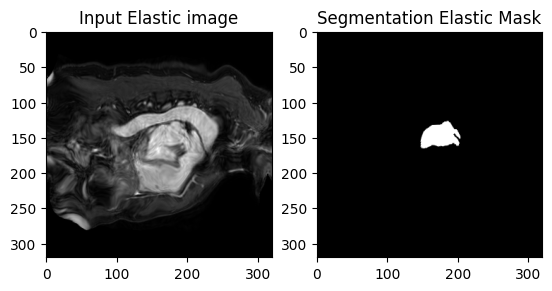

In [22]:
index = 1
ax = plt.subplot(1,2,1)
ax.imshow(X_train_elastic[index], cmap='gray')
ax.set_title('Input Elastic image')

ax = plt.subplot(1,2,2)
ax.imshow(Y_train_elastic[index], cmap='gray')
ax.set_title('Segmentation Elastic Mask')
plt.show()

In [23]:
print('num_train = {}, num_train_label = {}, num_test = {}'.format(len(X_train), len(Y_train), len(X_test)))
print('num_train_elastic = {}, num_train_label_elastic = {}, num_test = {}'.format(len(X_train_elastic), len(Y_train_elastic), len(X_test)))
print('num_train_crop = {}, num_train_label_crop = {}, num_test = {}'.format(len(X_train_crop), len(Y_train_crop), len(X_test)))

num_train = 160, num_train_label = 160, num_test = 40
num_train_elastic = 320, num_train_label_elastic = 320, num_test = 40
num_train_crop = 1440, num_train_label_crop = 1440, num_test = 40


In [24]:
# np.save('X_train.npy', X_train)
# np.save('Y_train.npy', Y_train)
# np.save('X_test.npy', X_test)
# np.save('Y_test.npy', Y_test)
# np.save('X_train_augmented.npy', X_train_augmented)
# np.save('Y_train_augmented.npy', Y_train_augmented)

## Sample Display of Augmented Data

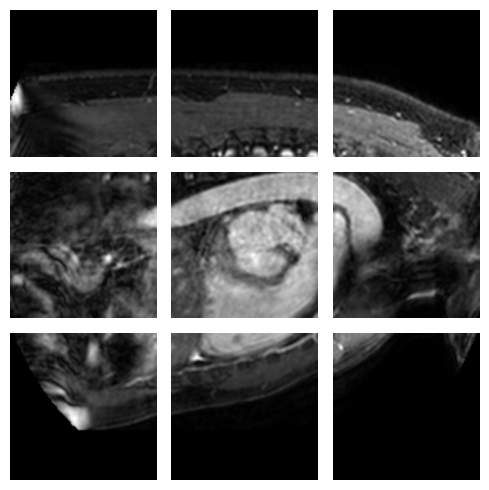

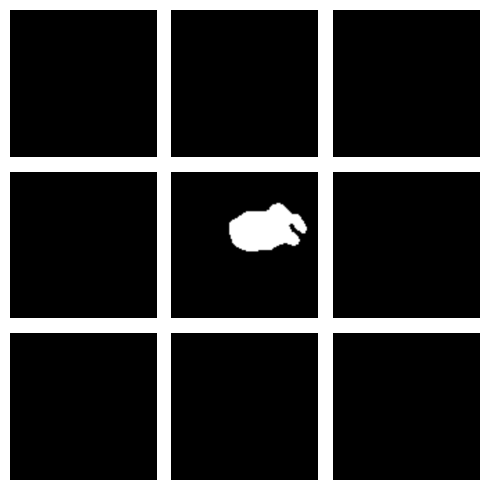

In [27]:
def visualize_augmented_patches(patches, num_patches):

    num_images = len(patches)
    num_rows = num_images // num_patches[1]
    
    fig, axs = plt.subplots(num_rows, num_patches[1], figsize=(5, 5))
    
    for i, ax in enumerate(axs.flatten()):
        if i < num_images:
            ax.imshow(patches[i], cmap='gray')
            ax.axis('off')
        else:
            ax.set_visible(False)
    
    plt.tight_layout()
    plt.show()

visualize_augmented_patches(X_train_crop[:9], (3,3))
visualize_augmented_patches(Y_train_crop[:9], (3,3))

In [26]:
# Data Normalization
# X_train = X_train / X_train.max()
# X_test = X_test / X_test.max()

In [19]:
X_train[0].max()

0.8179500254971953

In [20]:
Y_train /= X_train.max()

In [21]:
Y_train[0].max()

1.0

## Train Model

In [42]:
# Define model and parameter
shallow_model = unet_2d_shallow()
deep_model = unet_2d()
model_name = 'shallow_og..keras'
loss = 'binary_crossentropy'
batch_size = 10

In [43]:
def train(model, model_name, X_train, Y_train, loss, batch_size):
    model.compile(optimizer=Adam(learning_rate=1e-2), loss = loss, metrics = [dice_coefficient])
    checkpointer = ModelCheckpoint(model_name, verbose=1, save_best_only=True)
    earlystopper = EarlyStopping(patience=5, monitor='val_loss')
    result = model.fit(X_train, Y_train, epochs=100, batch_size = batch_size, validation_split=0.2, callbacks=[checkpointer, earlystopper])

    return result

In [44]:
shallow_og = train(shallow_model, 'shallow_og.keras', X_train, Y_train, loss, batch_size)
shallow_elastic = train(shallow_model, 'shallow_elastic.keras', X_train_elastic, Y_train_elastic, loss, batch_size)
shallow_crop = train(shallow_model, 'shallow_crop.keras', X_train_crop, Y_train_crop, loss, batch_size)

Epoch 1/100
13/13 [==============================] - ETA: 0s - loss: 0.9041 - dice_coefficient: 0.0968
Epoch 1: val_loss improved from inf to 0.98702, saving model to shallow_og.keras
13/13 [==============================] - 6s 400ms/step - loss: 0.9041 - dice_coefficient: 0.0968 - val_loss: 0.9870 - val_dice_coefficient: 0.0132
Epoch 2/100
13/13 [==============================] - ETA: 0s - loss: 0.7976 - dice_coefficient: 0.2023
Epoch 2: val_loss did not improve from 0.98702
13/13 [==============================] - 5s 365ms/step - loss: 0.7976 - dice_coefficient: 0.2023 - val_loss: 0.9870 - val_dice_coefficient: 0.0132
Epoch 3/100
13/13 [==============================] - ETA: 0s - loss: 0.6701 - dice_coefficient: 0.3312
Epoch 3: val_loss did not improve from 0.98702
13/13 [==============================] - 5s 364ms/step - loss: 0.6701 - dice_coefficient: 0.3312 - val_loss: 0.9870 - val_dice_coefficient: 0.0132
Epoch 4/100
13/13 [==============================] - ETA: 0s - loss: 0.6225

In [45]:
deep_og = train(deep_model, 'deep_og.keras', X_train, Y_train, loss, batch_size)
deep_elastic = train(deep_model, 'deep_elastic.keras', X_train_elastic, Y_train_elastic, loss, batch_size)
deep_crop = train(deep_model, 'deep_crop.keras', X_train_crop, Y_train_crop, loss, batch_size)

Epoch 1/100
13/13 [==============================] - ETA: 0s - loss: 0.8956 - dice_coefficient: 0.1057
Epoch 1: val_loss improved from inf to 0.98702, saving model to deep_og.keras
13/13 [==============================] - 9s 543ms/step - loss: 0.8956 - dice_coefficient: 0.1057 - val_loss: 0.9870 - val_dice_coefficient: 0.0132
Epoch 2/100
13/13 [==============================] - ETA: 0s - loss: 0.6910 - dice_coefficient: 0.3125
Epoch 2: val_loss did not improve from 0.98702
13/13 [==============================] - 6s 474ms/step - loss: 0.6910 - dice_coefficient: 0.3125 - val_loss: 0.9998 - val_dice_coefficient: 3.2357e-04
Epoch 3/100
13/13 [==============================] - ETA: 0s - loss: 0.5544 - dice_coefficient: 0.4416
Epoch 3: val_loss did not improve from 0.98702
13/13 [==============================] - 6s 476ms/step - loss: 0.5544 - dice_coefficient: 0.4416 - val_loss: 0.9998 - val_dice_coefficient: 3.2346e-04
Epoch 4/100
13/13 [==============================] - ETA: 0s - loss: 0

Train Loss Comparison

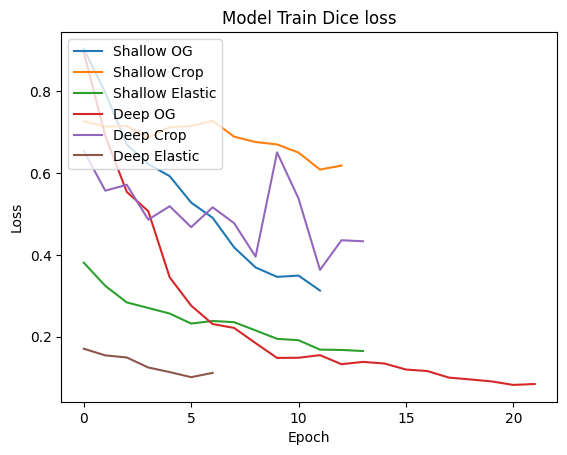

In [46]:
plt.plot(shallow_og.history['loss'], label='Shallow OG')
plt.plot(shallow_crop.history['loss'], label='Shallow Crop')
plt.plot(shallow_elastic.history['loss'], label='Shallow Elastic')
plt.plot(deep_og.history['loss'], label='Deep OG')
plt.plot(deep_crop.history['loss'], label='Deep Crop')
plt.plot(deep_elastic.history['loss'], label='Deep Elastic')

plt.title('Model Train Dice loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.savefig('Model Train Dice loss.png')
plt.show()

Validation Loss Comparison

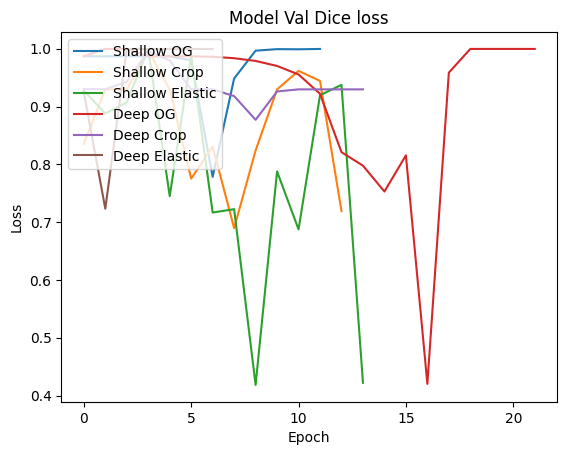

In [47]:
plt.plot(shallow_og.history['val_loss'], label='Shallow OG')
plt.plot(shallow_crop.history['val_loss'], label='Shallow Crop')
plt.plot(shallow_elastic.history['val_loss'], label='Shallow Elastic')
plt.plot(deep_og.history['val_loss'], label='Deep OG')
plt.plot(deep_crop.history['val_loss'], label='Deep Crop')
plt.plot(deep_elastic.history['val_loss'], label='Deep Elastic')

plt.title('Model Val Dice loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.savefig('Model Val Dice loss.png')

plt.show()

Train Dice Coefficient Comparison

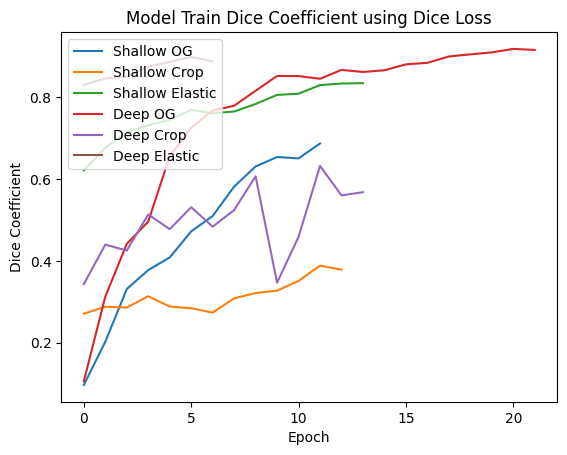

In [48]:
plt.plot(shallow_og.history['dice_coefficient'], label='Shallow OG')
plt.plot(shallow_crop.history['dice_coefficient'], label='Shallow Crop')
plt.plot(shallow_elastic.history['dice_coefficient'], label='Shallow Elastic')
plt.plot(deep_og.history['dice_coefficient'], label='Deep OG')
plt.plot(deep_crop.history['dice_coefficient'], label='Deep Crop')
plt.plot(deep_elastic.history['dice_coefficient'], label='Deep Elastic')

plt.title('Model Train Dice Coefficient using Dice Loss')
plt.ylabel('Dice Coefficient')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.savefig('Model Train Dice.png')

plt.show()


Val Dice Coefficient Comparison

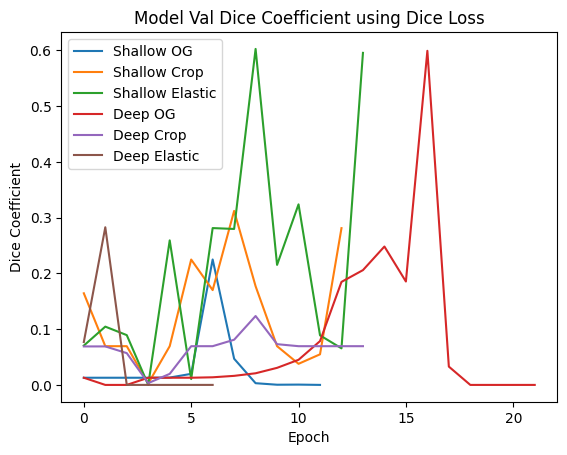

In [49]:
plt.plot(shallow_og.history['val_dice_coefficient'], label='Shallow OG')
plt.plot(shallow_crop.history['val_dice_coefficient'], label='Shallow Crop')
plt.plot(shallow_elastic.history['val_dice_coefficient'], label='Shallow Elastic')
plt.plot(deep_og.history['val_dice_coefficient'], label='Deep OG')
plt.plot(deep_crop.history['val_dice_coefficient'], label='Deep Crop')
plt.plot(deep_elastic.history['val_dice_coefficient'], label='Deep Elastic')

plt.title('Model Val Dice Coefficient using Dice Loss')
plt.ylabel('Dice Coefficient')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.savefig('Model Val Dice.png')

plt.show()

## Additional Performance Metrics

In [17]:
def calculate_confusion_matrix(y_true, y_pred):
    """
    Calculate confusion matrix components: TP, TN, FP, FN for flattened arrays
    """
    TP = np.sum((y_true == 1) & (y_pred == 1))
    TN = np.sum((y_true == 0) & (y_pred == 0))
    FP = np.sum((y_true == 0) & (y_pred == 1))
    FN = np.sum((y_true == 1) & (y_pred == 0))
    
    return TP, TN, FP, FN
    
def sensitivity(y_true, y_pred):
    """
    Calculate sensitivity (Recall) for flattened arrays
    """
    TP, TN, FP, FN = calculate_confusion_matrix(y_true, y_pred)
    sensitivity = TP / (TP + FN) if (TP + FN) != 0 else 0
    return sensitivity

def accuracy(y_true, y_pred):
    """
    Calculate accuracy for flattened arrays
    """
    TP, TN, FP, FN = calculate_confusion_matrix(y_true, y_pred)
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    return accuracy

def specificity(y_true, y_pred):
    """
    Calculate specificity for flattened arrays
    """
    TP, TN, FP, FN = calculate_confusion_matrix(y_true, y_pred)
    specificity = TN / (TN + FP) if (TN + FP) != 0 else 0
    return specificity


## Evaluate the Performance using Dice

In [44]:
directories = ['./BCE', './DICE']
# Y_test and Y_pred not flattened yet
Y_test = np.ravel(Y_test)  # Flatten the ground truth array


results = {}
for directory in directories:
    model_files = os.listdir(directory)  
    for model_file in model_files:
        if model_file.endswith('.keras'):  # Ensure to load only model files if there are other file types
            # Load the model
            model_path = os.path.join(directory, model_file)
            # model = unet_2d()
            model = load_model(model_path, custom_objects={'dice_coefficient': dice_coefficient, 'dice_loss':dice_loss})
    
            # Make predictions
            X_test = tf.convert_to_tensor(X_test, dtype=tf.double)
            y_pred = model.predict(X_test)
            
            y_pred_thresholded = (y_pred > 0.5).astype(np.float32)
            y_pred_thresholded = np.ravel(y_pred_thresholded)

            # Calculate the Dice Coefficient
            dice_score = dice_coefficient(Y_test, y_pred_thresholded)
            dice_score = np.round(dice_score,3)

            # Calculate accuracy and recall
            acc = accuracy(Y_test, y_pred_thresholded)
            sen = sensitivity(Y_test, y_pred_thresholded)
            sen = np.round(sen,3)
    
            # Append the result
            dir_name = os.path.basename(directory)  # Get the last part of the directory path as a label
            dice_col = "Dice score train by " + dir_name + " loss"
            recall_col = "Recall train by "+ dir_name + " loss"
            
            if dice_col not in results:
                results[dice_col] = {}
            if recall_col not in results:
                results[recall_col] = {}
            results[dice_col][model_file] = dice_score
            results[recall_col][model_file] = sen

2/2 [==============================] - 0s 226ms/step


In [45]:
df = pd.DataFrame(results)
cols = df.columns.tolist()
cols[1], cols[2] = cols[2], cols[1]
df = df[cols]
df

,Dice score train by BCE loss,Dice score train by DICE loss,Recall train by BCE loss,Recall train by DICE loss
deep_elastic.keras,0.606,0.319,0.934,0.958
deep_og.keras,0.000,0.585,0.000,0.957
deep_crop.keras,0.000,0.017,0.000,0.009
shallow_elastic.keras,0.535,0.825,0.384,0.911
shallow_crop.keras,0.000,0.376,0.000,0.388
shallow_og.keras,0.309,0.247,0.431,0.991


In [55]:
df_results.columns = ['Dice Score from BCE Loss Model', 'Dice Score from Dice Loss Model']
df_results

,Dice Score from BCE Loss Model,Dice Score from Dice Loss Model
deep_elastic,0.606,0.319
deep_og,0.000,0.585
deep_crop,0.000,0.017
shallow_elastic,0.535,0.825
shallow_crop,0.000,0.376
shallow_og,0.309,0.247


## Best model prediction - Shallow U-net with Elastic Deformation

In [17]:
best = load_model('./DICE/shallow_og.keras',custom_objects={'dice_coefficient': dice_coefficient, 'dice_loss':dice_loss})
y_pred = best.predict(X_test)

2024-03-28 13:40:36.373465: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-28 13:40:36.519341: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 18274 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe MIG 2g.20gb, pci bus id: 0000:e3:00.0, compute capability: 8.0
2024-03-28 13:40:37.959084: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8906


1/2 [==============>...............] - ETA: 8s

2024-03-28 13:40:45.852288: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


2/2 [==============================] - 10s 2s/step


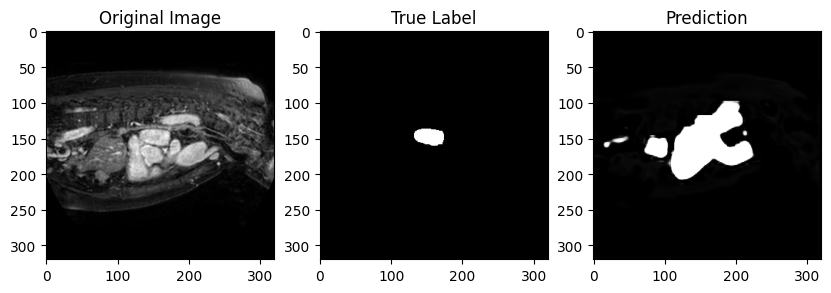

In [52]:
# Example usage
index = 0 # Index of the image you want to visualize
plot_predictions(X_test, Y_test, y_pred, index)

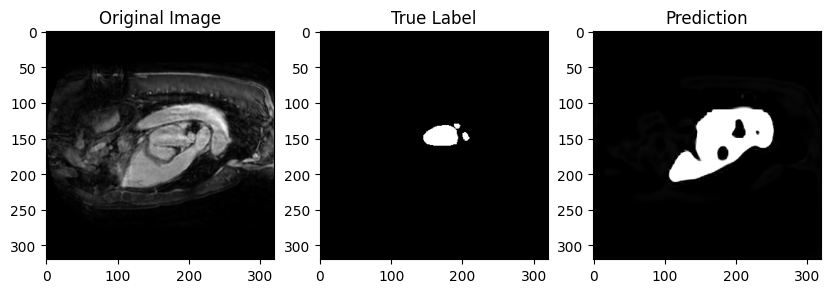

In [18]:
index = 30 # Index of the image you want to visualize
plot_predictions(X_test, Y_test, y_pred, index)

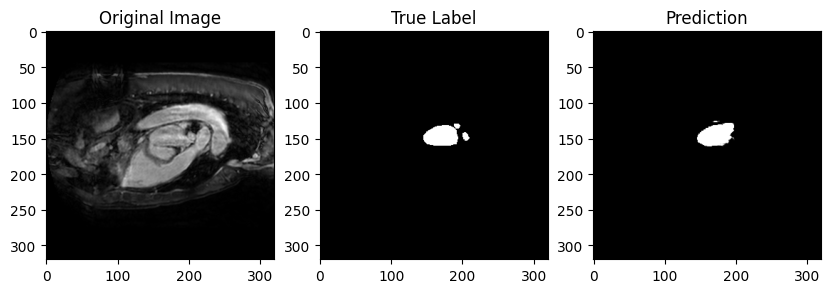

In [58]:
plot_predictions(X_test, Y_test, y_pred, 30)